# CS 6220 Data Mining Techniques: Final Project

## Leukemia Classification Based on Gene Expression

#### *Authors: Lindsey Alexanian, Dhruv Doshi, Shital Waters*

In [2]:
%%time

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
import warnings
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

CPU times: total: 1.08 s
Wall time: 19.7 s


# Preprocessing dataset

In [225]:
# read in the data (the data has been pre-split into train and test data)
train_data = pd.read_csv("data_set_ALL_AML_train.csv")
test_data = pd.read_csv("data_set_ALL_AML_independent.csv")
labels = pd.read_csv("actual.csv")

In [226]:
# put all data together (if we want to test different splits of data, etc.)
golub = pd.concat([train_data,test_data], axis=1)

# view
golub

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-256,A,-191,A,-172,A,-496,A,-294,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,793,A,782,A,1138,A,627,A,...,707,A,423,A,809,A,466,A,551,A
7125,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,329,A,295,A,777,P,170,A,...,354,A,41,A,445,A,349,A,194,A
7126,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,36,A,11,A,41,A,-50,A,...,-22,A,0,A,-2,A,0,A,20,A
7127,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,191,A,76,A,228,A,126,A,...,260,A,1777,P,210,A,284,A,379,A


In [227]:
# drop extra columns
cols_drop = [col for col in train_data.columns if "call" in col]
cols_drop.append("Gene Description")
golub.drop(columns=cols_drop, inplace=True)

# make Gene Accession Number the index of the df
golub.set_index("Gene Accession Number", inplace=False)

,1,2,3,4,5,6,7,8,9,10,...,54,57,58,60,61,65,66,63,64,62
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,
"(AFFX-BioB-5_at, AFFX-BioB-5_at)",-214,-139,-76,-135,-106,-138,-72,-413,5,-88,...,-90,-137,-157,-172,-47,-62,-58,-161,-48,-176
"(AFFX-BioB-M_at, AFFX-BioB-M_at)",-153,-73,-49,-114,-125,-85,-144,-260,-127,-105,...,-87,-51,-370,-122,-442,-198,-217,-215,-531,-284
"(AFFX-BioB-3_at, AFFX-BioB-3_at)",-58,-1,-307,265,-76,215,238,7,106,42,...,102,-82,-77,38,-21,-5,63,-46,-124,-81
"(AFFX-BioC-5_at, AFFX-BioC-5_at)",88,283,309,12,168,71,55,-2,268,219,...,319,178,340,31,396,141,95,146,431,9
"(AFFX-BioC-3_at, AFFX-BioC-3_at)",-295,-264,-376,-419,-230,-272,-399,-541,-210,-178,...,-283,-135,-438,-201,-351,-256,-191,-172,-496,-294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(X83863_at, X83863_at)",793,782,1138,627,250,645,1140,1799,758,570,...,618,507,1372,87,1111,707,423,809,466,551
"(Z17240_at, Z17240_at)",329,295,777,170,314,341,482,446,385,359,...,308,64,642,98,459,354,41,445,349,194
"(L49218_f_at, L49218_f_at)",36,11,41,-50,14,26,10,59,115,9,...,0,-11,-9,-26,-8,-22,0,-2,0,20


In [228]:
# change shape (labels on y instead of x)
golub = golub.T
golub

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-62,-198,-5,141,-256,-206,-298,-218,-14,100,...,92,532,-34,239,-78,707,354,-22,260,5
66,-58,-217,63,95,-191,-230,-86,-152,-6,-249,...,63,297,36,358,2,423,41,0,1777,-49
63,-161,-215,-46,146,-172,-596,-122,-341,171,-147,...,130,639,-27,548,-39,809,445,-2,210,16
64,-48,-531,-124,431,-496,-696,-1038,-441,235,157,...,84,1141,-121,197,-108,466,349,0,284,-73


In [229]:
# view the labels
labels

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL
...,...,...
67,68,ALL
68,69,ALL
69,70,ALL
70,71,ALL


In [230]:
# change header
golub.columns = golub.iloc[0]
# drop first row
golub = golub.drop(golub.index[0])

In [231]:
golub

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-62,-198,-5,141,-256,-206,-298,-218,-14,100,...,92,532,-34,239,-78,707,354,-22,260,5
66,-58,-217,63,95,-191,-230,-86,-152,-6,-249,...,63,297,36,358,2,423,41,0,1777,-49
63,-161,-215,-46,146,-172,-596,-122,-341,171,-147,...,130,639,-27,548,-39,809,445,-2,210,16
64,-48,-531,-124,431,-496,-696,-1038,-441,235,157,...,84,1141,-121,197,-108,466,349,0,284,-73


In [232]:
labels

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL
...,...,...
67,68,ALL
68,69,ALL
69,70,ALL
70,71,ALL


In [233]:
# split to train and test data - 75 / 25 (was originally 80 / 20, but that made the test set too small)
X_train, X_test, y_train, y_test = train_test_split(golub, labels.cancer, test_size=0.25, random_state=10)

In [234]:
# scale the features using StandardScaler
scaler = StandardScaler()
# scale train
X_train = scaler.fit_transform(X_train)
# scale test
X_test = scaler.transform(X_test)

# K Nearest Neighbors (KNN) Classifier

In [ ]:
# Reference: https://www.digitalocean.com/community/tutorials/k-nearest-neighbors-knn-in-python

In [235]:
# initialize kNN where k=3
knn = KNeighborsClassifier(n_neighbors=3)
# fit to train data
knn.fit(X_train, y_train)

knn

KNeighborsClassifier(n_neighbors=3)

In [236]:
# make predictions on test data
test_pred = knn.predict(X_test)

# find accuracy on test data
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Accuracy: {test_accuracy}")

Accuracy: 0.6111111111111112


### KNN with hyperparameter tuning

In [237]:
%%time

# let's try some cross validation

# we'll do 20 reps
k_values = [i for i in range (1,20)]
scores = []

# scale data
scaler = StandardScaler()
X = scaler.fit_transform(golub)

# run tests for cross val scores
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, labels.cancer, cv=5)
    scores.append(np.mean(score))

CPU times: user 1.21 s, sys: 93 ms, total: 1.31 s
Wall time: 893 ms


In [238]:
print(scores)

[0.58, 0.6923809523809523, 0.6066666666666667, 0.6914285714285714, 0.6333333333333334, 0.6638095238095237, 0.6628571428571428, 0.7761904761904762, 0.7485714285714286, 0.7628571428571429, 0.7752380952380953, 0.7761904761904762, 0.7761904761904762, 0.720952380952381, 0.7342857142857143, 0.6942857142857143, 0.7352380952380952, 0.680952380952381, 0.6657142857142857]


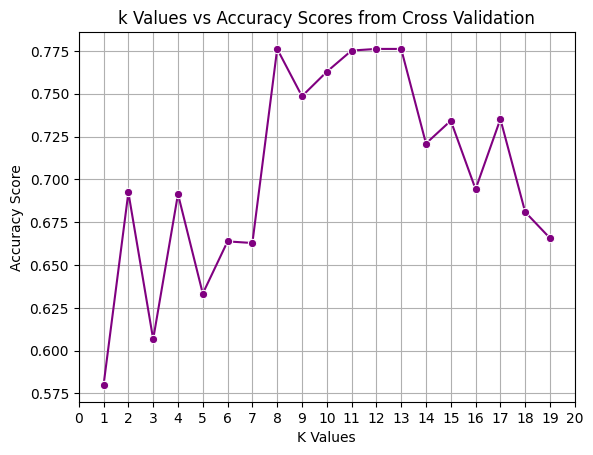

In [239]:
sns.lineplot(x = k_values, y = scores, marker = 'o', color="purple")
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.grid()
plt.xticks(np.arange(0, 21, 1.0))
plt.title("k Values vs Accuracy Scores from Cross Validation")
plt.show()

In [240]:
%%time
# can also try elbow curve
error_rate = []

# loop through potential k values
for i in range(1,20):

    knn_elbow = KNeighborsClassifier(n_neighbors=i)
    knn_elbow.fit(X_train,y_train)
    pred_i = knn_elbow.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

CPU times: user 173 ms, sys: 0 ns, total: 173 ms
Wall time: 108 ms


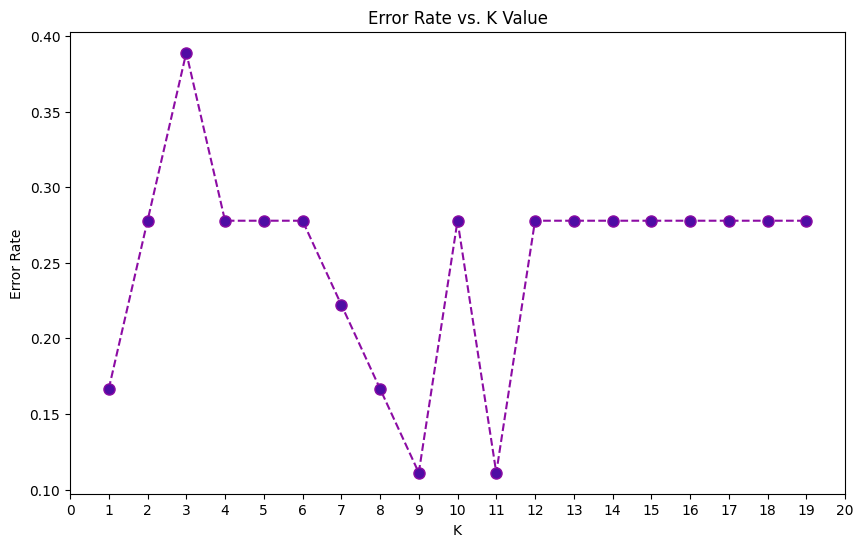

In [241]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,linestyle='dashed',color='#8C0CA4',marker='o',markerfacecolor='#4F0CA4',markersize=8)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.xticks(np.arange(0, 21, 1.0))
plt.show()

# okay, this is a very wonky elbow curve

In [242]:
# try again based on data above

# initialize kNN where k=9
knn2 = KNeighborsClassifier(n_neighbors=9)
# fit to train data
knn2.fit(X_train, y_train)

knn2

KNeighborsClassifier(n_neighbors=9)

In [243]:
# make predictions on the test data
y_pred_knn = knn2.predict(X_test)

# find accuracy! (again)
test_accuracy2 = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {test_accuracy2}")

Accuracy: 0.8888888888888888


In [244]:
# classification report
knn2_class_report = sklearn.metrics.classification_report(y_test, y_pred_knn)
print(knn2_class_report)

              precision    recall  f1-score   support

         ALL       0.86      1.00      0.92        12
         AML       1.00      0.67      0.80         6

    accuracy                           0.89        18
   macro avg       0.93      0.83      0.86        18
weighted avg       0.90      0.89      0.88        18



In [245]:
# get precision, recall, and f-score metrics for this model
p_r_f1 = sklearn.metrics.precision_recall_fscore_support(y_test,y_pred_knn, average="macro")

print(f"Precision score: {p_r_f1[0]}")
print(f"Recall score: {p_r_f1[1]}")

Precision score: 0.9285714285714286
Recall score: 0.8333333333333333


# Decision Tree

In [257]:
# Reference: https://scikit-learn.org/stable/modules/tree.html
# https://www.datacamp.com/tutorial/decision-tree-classification-python

In [246]:
# create tree model
tree_model = tree.DecisionTreeClassifier(random_state=1, max_features="sqrt")

# fit model on training data
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_features='sqrt', random_state=1)

In [247]:
# check training accuracy
acc_train = tree_model.score(X_train, y_train)

# perfect score on train data
acc_train

1.0

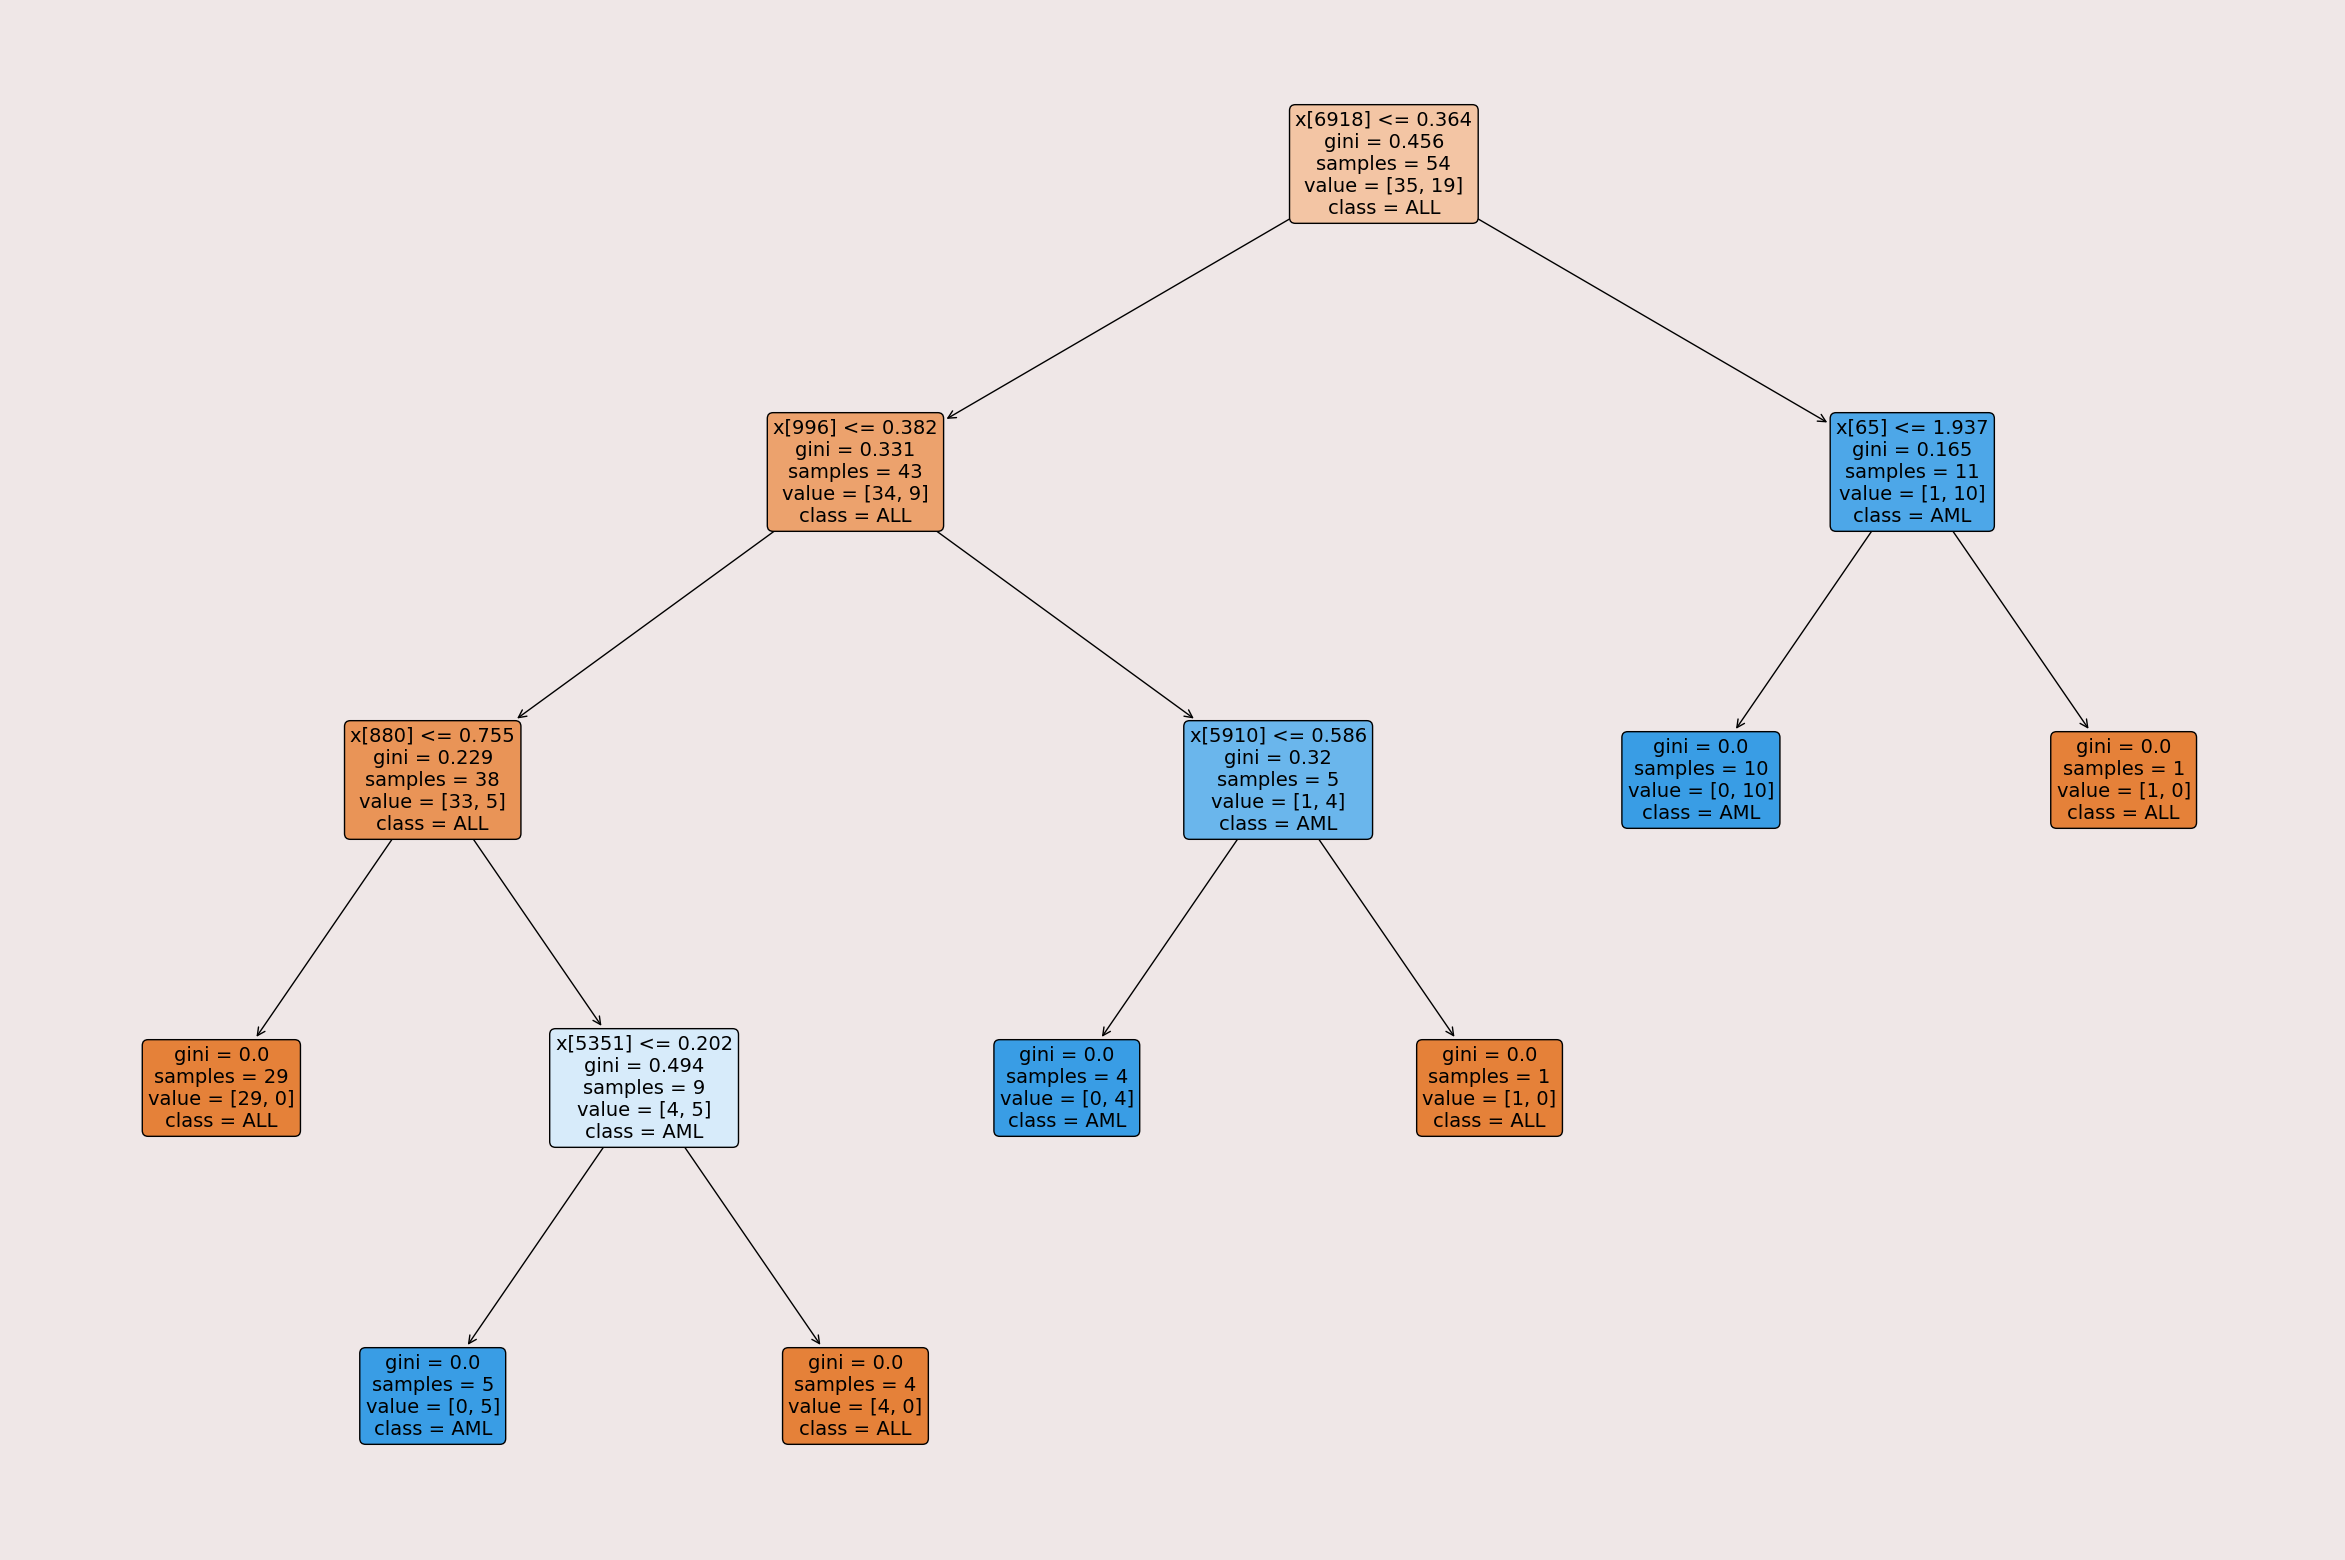

In [248]:
# create figure
plt.figure(figsize=(30,20), facecolor ='#EFE7E7')

# create the tree plot
a = tree.plot_tree(tree_model,
                   rounded = True,
                   filled = True,
                   class_names = ["ALL","AML"],
                   fontsize=14)
# show the plot! (depth is 4)
plt.show()

In [249]:
# predictions on test data!
y_pred_dt = tree_model.predict(X_test)

# find accuracy
tree_score = accuracy_score(y_test, y_pred_dt)

# print
print(f"Test accuracy score: {tree_score}")

Test accuracy score: 0.7222222222222222


In [250]:
# get precision, recall, and f-score metrics for this model
p_r_f = sklearn.metrics.precision_recall_fscore_support(y_test,y_pred_dt,
                                                        average="macro")

print(f"Precision score: {p_r_f[0]}")
print(f"Recall score: {p_r_f[1]}")

Precision score: 0.7222222222222222
Recall score: 0.75


In [251]:
# classification report
tree_class_report = sklearn.metrics.classification_report(y_test, y_pred_dt)
print(tree_class_report)

              precision    recall  f1-score   support

         ALL       0.89      0.67      0.76        12
         AML       0.56      0.83      0.67         6

    accuracy                           0.72        18
   macro avg       0.72      0.75      0.71        18
weighted avg       0.78      0.72      0.73        18



## Logistic regression with Hyperparameter tuning

In [ ]:
# Reference: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

In [252]:
warnings.filterwarnings('ignore')

# Using grid search to find the best combination of hyperparameters
# for the logistic regression model.

# 1. Using L1 Lasso as the penalty for tuning

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state = 10, solver='liblinear'),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

best_lr_1 = grid_search.best_estimator_

y_pred_lr_tuned_1 = best_lr_1.predict(X_test)
accuracy_lr_tuned_1 = accuracy_score(y_test, y_pred_lr_tuned_1)
print("Tuned Logistic Regression Accuracy with L1 Lasso:", accuracy_lr_tuned_1)

# 2. Using L2 Ridge as the penalty for tuning

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': [None, 'l2']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state = 10),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

best_lr_2 = grid_search.best_estimator_

y_pred_lr_tuned_2 = best_lr_2.predict(X_test)
accuracy_lr_tuned_2 = accuracy_score(y_test, y_pred_lr_tuned_2)
print("Tuned Logistic Regression Accuracy with L2 Ridge:", accuracy_lr_tuned_2)

# Compare both the accuracies. Store the predictions of the LR model which
# gives better predictions.
if accuracy_lr_tuned_1 > accuracy_lr_tuned_2:
  y_pred_lr = y_pred_lr_tuned_1
else:
  y_pred_lr = y_pred_lr_tuned_2


# Classification report
print(sklearn.metrics.classification_report(y_test, y_pred_lr))

Tuned Logistic Regression Accuracy with L1 Lasso: 0.8888888888888888
Tuned Logistic Regression Accuracy with L2 Ridge: 0.8333333333333334
              precision    recall  f1-score   support

         ALL       0.92      0.92      0.92        12
         AML       0.83      0.83      0.83         6

    accuracy                           0.89        18
   macro avg       0.88      0.88      0.88        18
weighted avg       0.89      0.89      0.89        18



## Random Forest

In [258]:
# Reference: https://www.datacamp.com/tutorial/random-forests-classifier-python

In [253]:
# Creating a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)

# Fitting the model
rf.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf.predict(X_train)

# Evaluating the training accuracy
accuracy = accuracy_score(y_train, y_pred_rf)
print(f'Training accuracy: {accuracy}')

Training accuracy: 1.0


### Random Forest with hyperparameter tuning

In [254]:
# defining param_grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# performing grid search with cross-validation, to find best params
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state = 23),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# store the best params
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# build model using the best params
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

# make predictions
y_pred_rf = best_rf.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_rf)
print(f'Best model accuracy on test data: {accuracy_best}')

# Classification report
print(sklearn.metrics.classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best model accuracy on test data: 0.7777777777777778
              precision    recall  f1-score   support

         ALL       0.79      0.92      0.85        12
         AML       0.75      0.50      0.60         6

    accuracy                           0.78        18
   macro avg       0.77      0.71      0.72        18
weighted avg       0.77      0.78      0.76        18



## Ensemble models (KNN, decision tree, logistic regression and random forest)

In [270]:
# take results from all the models and make final prediction based on the
# most voted class. Breaking ties by randomizing.

def mostFreqElement(my_list):
  element_counts = Counter(my_list)
  max_frequency = max(element_counts.values())
  return random.choice([element for element, count in element_counts.items()
  if count == max_frequency])

y_pred_final = []
for i in range(0, len(y_pred_knn)):
  y_pred_final.append(mostFreqElement([y_pred_knn[i], y_pred_dt[i], y_pred_lr[i],
                                     y_pred_rf[i]]))

# Classification report
print(sklearn.metrics.classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

         ALL       0.92      1.00      0.96        12
         AML       1.00      0.83      0.91         6

    accuracy                           0.94        18
   macro avg       0.96      0.92      0.93        18
weighted avg       0.95      0.94      0.94        18

